# Classification of Montreal Metro stations

## Introduction

Montreal Metro has 68 stations and has one of North America's busiest public transportation systems with, after New York, the largest number of users compared to its population. In 2018, more than 1.3 million people using metro system in Montreal daily.  
The Montreal Metro is Canada's second busiest rapid transit system. Besdie, considering the Montreal urban environment and society, for any bussiness it is so crucial to consider underground system to locate the bussiness.  
For this project, the neighborhoods surrounding metro stations will be classified. Some neighborhoods are mostly residential, some have more business or commercial spaces surrounding them. The venues closest to a station determine why and how people use it, e.g. if there are no professional places in a neighborhood its residents are likely to travel to other areas for work. This creates daily migrations of people.  
By analyzing this data we can classify stations by primary usage. This data is useful for city planners to determine where from and where to people are most likely to travel for work and leisure. This can help plan further extension of the network and find places for new development.

## Data

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

!pip -q install geopy 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

# install and import folium library 
!pip -q install folium
import folium

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

### List of stations and their geographical coordinates
The list of stations will be gathered from **Foursquare City Guide**. to this end, the fist step will be finding geographical coordinate of Montreal, QC:

In [2]:
address = 'Montreal'

geolocator = Nominatim(user_agent="myGeocoder")
location   = geolocator.geocode(address)
latitude   = location.latitude
longitude  = location.longitude

print('The geographical coordinate of Montreal are {}, {}.'.format(latitude, longitude))

The geographical coordinate of Montreal are 45.4972159, -73.6103642.


In [3]:
CLIENT_ID = '3HBDPILEY41WD5VPJ15VOUYEUNGEXCT13VETJH5EKLD53E2W' # your Foursquare ID
CLIENT_SECRET = 'Q0UPMKP3FBLJVLMFUFDJ00KXD42FXNXWZM1KAITX0JEZXEC0' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [4]:
LIMIT = 150 # limit of number of venues returned by Foursquare API

radius = 15000 # define radius

categoryId = '4bf58dd8d48988d1fd931735' #  Foursquare categoryId for metro stations (see: https://developer.foursquare.com/docs/build-with-foursquare/categories/)

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude,
    categoryId,
    radius, 
    LIMIT)


# make the GET request

results = requests.get(url).json()

#### Basic Cleanup

In [5]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [6]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# Rename headers
nearby_venues.rename(columns={"venue.name": "Name", "venue.location.lat": "Latitude", "venue.location.lng":"Longitude"},inplace = True)

stations_venues_df = nearby_venues[nearby_venues["Name"].str.startswith("STM Station")]
stations_venues_df.reset_index(drop=True, inplace=True)

# Removing 'STM' in front of name of sations for clearity
stations_venues_df['Name'] = stations_venues_df['Name'].str.replace('STM ','')

# The DataFrame will be:
stations_venues_df.head(10)

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Name,Latitude,Longitude
0,Station Guy-Concordia,45.494677,-73.580909
1,Station McGill,45.504365,-73.571575
2,Station Saint-Michel,45.559425,-73.599749
3,Station Université-de-Montréal,45.503466,-73.618103
4,Station de la Côte-des-Neiges,45.496377,-73.622564
5,Station Bonaventure,45.498205,-73.566667
6,Station Édouard-Montpetit,45.509822,-73.612816
7,Station de Vendôme,45.473825,-73.604328
8,Station de la Place-Saint-Henri,45.477212,-73.586523
9,Station Mont-Royal,45.524560,-73.581798


#### Visulizing the locations of stations

In [7]:
# create map of Montreal using latitude and longitude values
map_montreal_metro = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, name in zip(stations_venues_df['Latitude'], stations_venues_df['Longitude'], stations_venues_df['Name']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        color='#EF161E',
        fill=True,
        fill_color='#FFD702',
        fill_opacity=0.7,
        parse_html=False).add_to(map_montreal_metro)  

    
map_montreal_metro

In [8]:
map_montreal_metro.save('ini_map\index.html')

## Venues and categories
Foursquare API will be called again to explore venue categories surrounding each station. Venues can be categorized as residential, professional, shopping or leisure.

In [9]:
# create URL
categories_url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION)


# make the GET request

results = requests.get(categories_url).json()

len(results['response']['categories'])

10

In [10]:
categories_list = []
# Let's print only the top-level categories and their IDs and also add them to categories_list

def print_categories(categories, level=0, max_level=0):    
    if level>max_level: return
    out = ''
    out += '-'*level
    for category in categories:
        print(out + category['name'] + ' (' + category['id'] + ')')
        print_categories(category['categories'], level+1, max_level)
        categories_list.append((category['name'], category['id']))
        
print_categories(results['response']['categories'], 0, 0)

Arts & Entertainment (4d4b7104d754a06370d81259)
College & University (4d4b7105d754a06372d81259)
Event (4d4b7105d754a06373d81259)
Food (4d4b7105d754a06374d81259)
Nightlife Spot (4d4b7105d754a06376d81259)
Outdoors & Recreation (4d4b7105d754a06377d81259)
Professional & Other Places (4d4b7105d754a06375d81259)
Residence (4e67e38e036454776db1fb3a)
Shop & Service (4d4b7105d754a06378d81259)
Travel & Transport (4d4b7105d754a06379d81259)


## Methodology 

We can use the foursquare explore API with category Id to query the number of venues of each category in a specific radius. The response contains a total Results value for the specified coordinates, radius and category.

In [11]:
def get_venues_count(latitude,longitude, radius, categoryId):
    explore_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION,
                latitude, 
                longitude,
                radius,
                categoryId)

    # make the GET request
    return requests.get(explore_url).json()['response']['totalResults']


In [12]:
#Create new dataframe to store venues data
venues_df = stations_venues_df.copy()
for c in categories_list:
    venues_df[c[0]] = 0

In [13]:
#Request number of venues, store result as CSV
for inx, row in venues_df.iterrows():
    for c in categories_list:        
        venues_df.loc[inx, c[0]] = get_venues_count(venues_df.Latitude[inx],venues_df.Longitude[inx], radius=1000, categoryId=c[1])
    venues_df.head()
    venues_df.to_csv('stations_venues.csv')

In [25]:
#Read already stored CSV
venues_df = pd.read_csv('stations_venues.csv', index_col=0)

### Exploratory analysis & basic cleanup
Plot the number of venues as boxplots

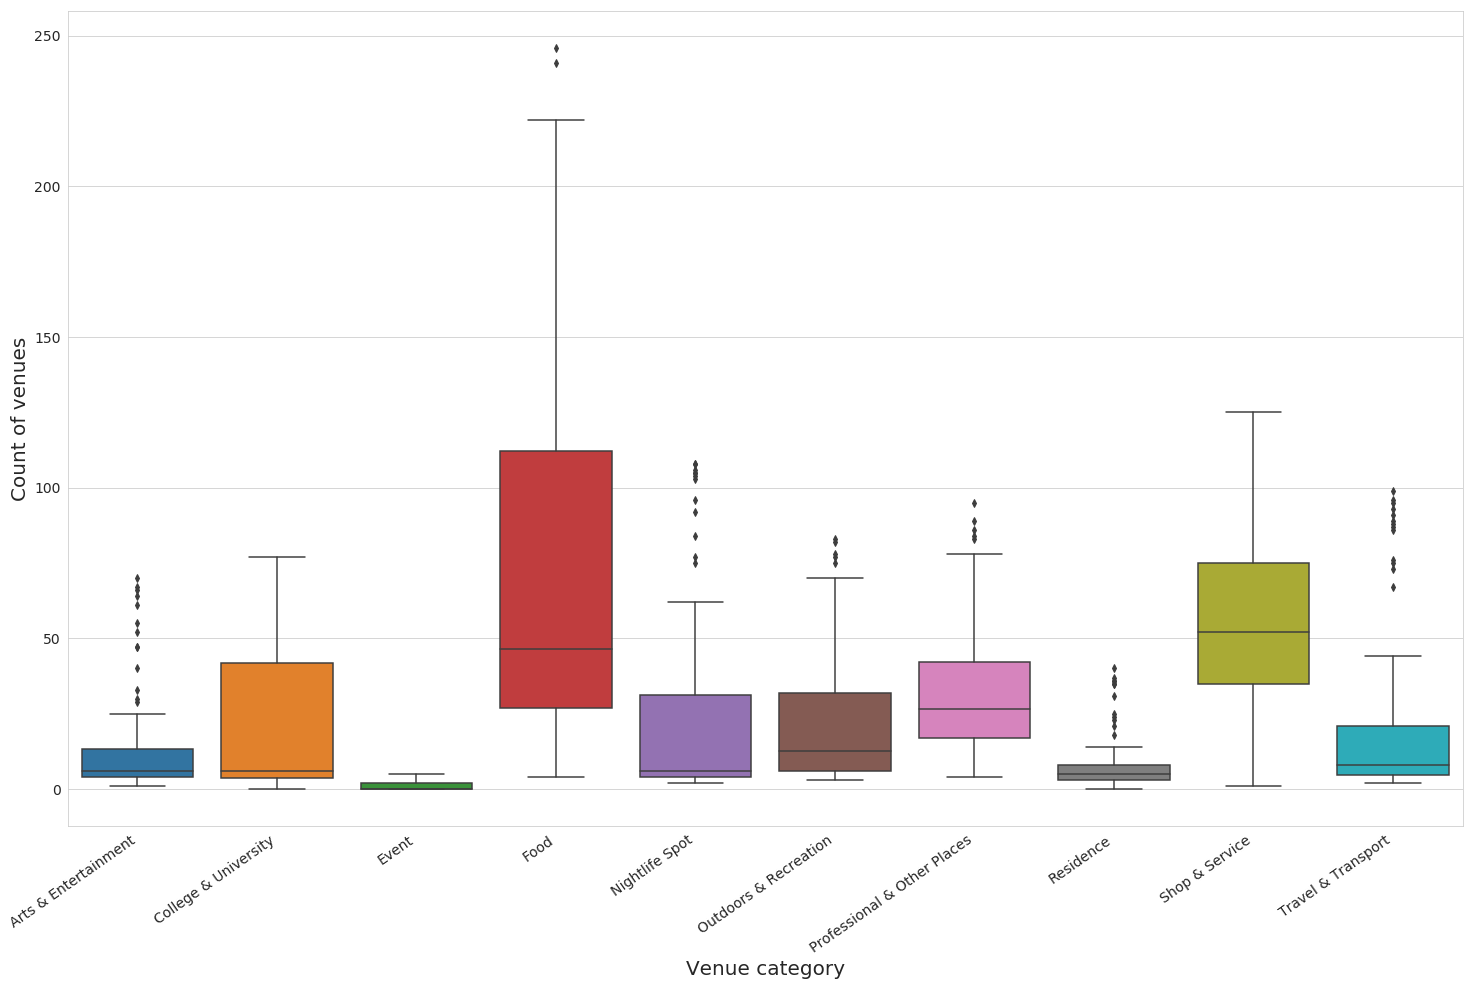

In [26]:
plt.figure(figsize=(25, 15))
plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.boxplot(data = venues_df.drop(columns=['Latitude','Longitude']))
ax.set_ylabel('Count of venues', fontsize=20)
ax.set_xlabel('Venue category', fontsize=20)
ax.tick_params(labelsize=14)
plt.xticks(rotation=35, ha='right')
sns.set_style("whitegrid")

plt.show()

The most frequent venue categories are shop&service and food. Event has very little data, let's discard it from both the dataframe and the list of categories.

In [27]:
venues_df.drop('Event', 1, inplace=True)

In [28]:
categories_list = list(filter(lambda x: x[0] != 'Event', categories_list))

### Data preparation

The data will be normalized by MinMaxScaler method (scale from 0 to 1), which provides easier interpretion score.

In [29]:
from sklearn.preprocessing import MinMaxScaler

X = venues_df.values[:,3:].astype(float)
cluster_dataset = MinMaxScaler().fit_transform(X)

In [30]:
cluster_df = pd.DataFrame(cluster_dataset)
cluster_df.columns = [c[0] for c in categories_list]

let's visualize the scaled data.

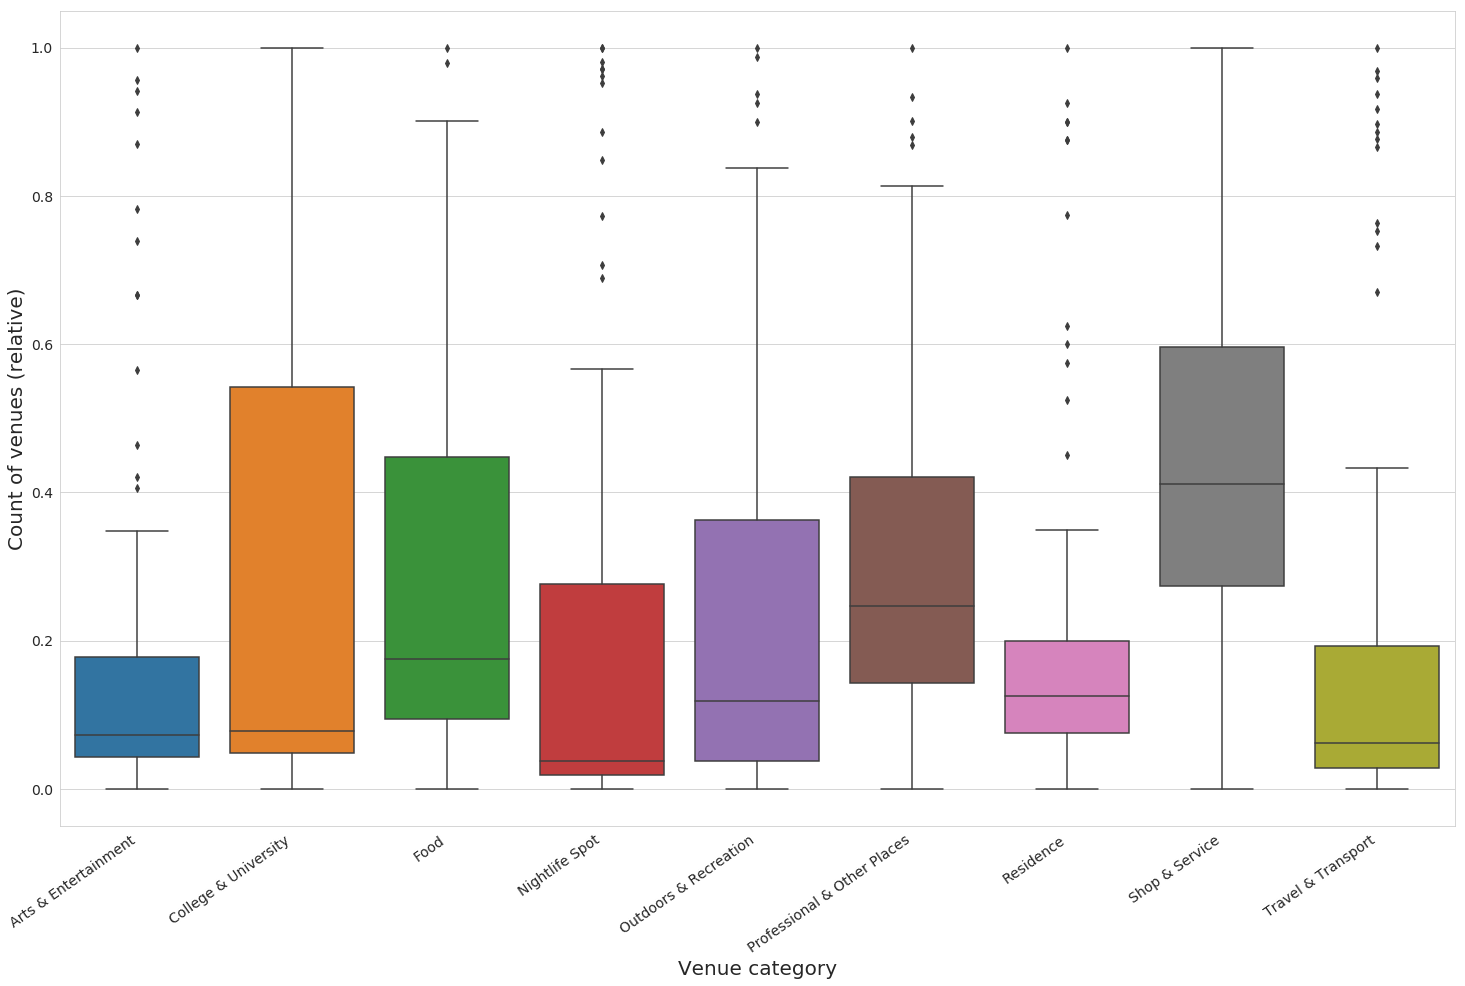

In [31]:
plt.figure(figsize=(25, 15))
plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.boxplot(data = cluster_df)
ax.set_ylabel('Count of venues (relative)', fontsize=20)
ax.set_xlabel('Venue category', fontsize=20)
ax.tick_params(labelsize=14)
plt.xticks(rotation=35, ha='right')

plt.show()

# Clustering
K-means will be employed for clustring.
These were preliminary results with different number of clusters:  
- 2 clusters only show the uptown/downtown divide
- 3 clusters add clustering within the downtown
- 4 clusters also identify neighborhoods with very low number of venues
- 5 and more clusters are difficult to interpret  

For the final analysis let's settle on 4 clusters.

In [32]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cluster_df)

kmeans_labels = kmeans.labels_
# Change label numbers so they go from highest scores to lowest
replace_labels = {0:2, 1:0, 2:3, 3:1}
for i in range(len(kmeans_labels)):
    kmeans_labels[i] = replace_labels[kmeans_labels[i]]

stations_clusters_df = venues_df.copy()
stations_clusters_df['Cluster'] = kmeans_labels
stations_clusters_minmax_df = cluster_df.copy()
stations_clusters_minmax_df['Cluster'] = kmeans_labels
stations_clusters_minmax_df['Name'] = stations_venues_df['Name']
stations_clusters_minmax_df['Latitude'] = stations_venues_df['Latitude']
stations_clusters_minmax_df['Longitude'] = stations_venues_df['Longitude']

Visualize the clusters with boxplots

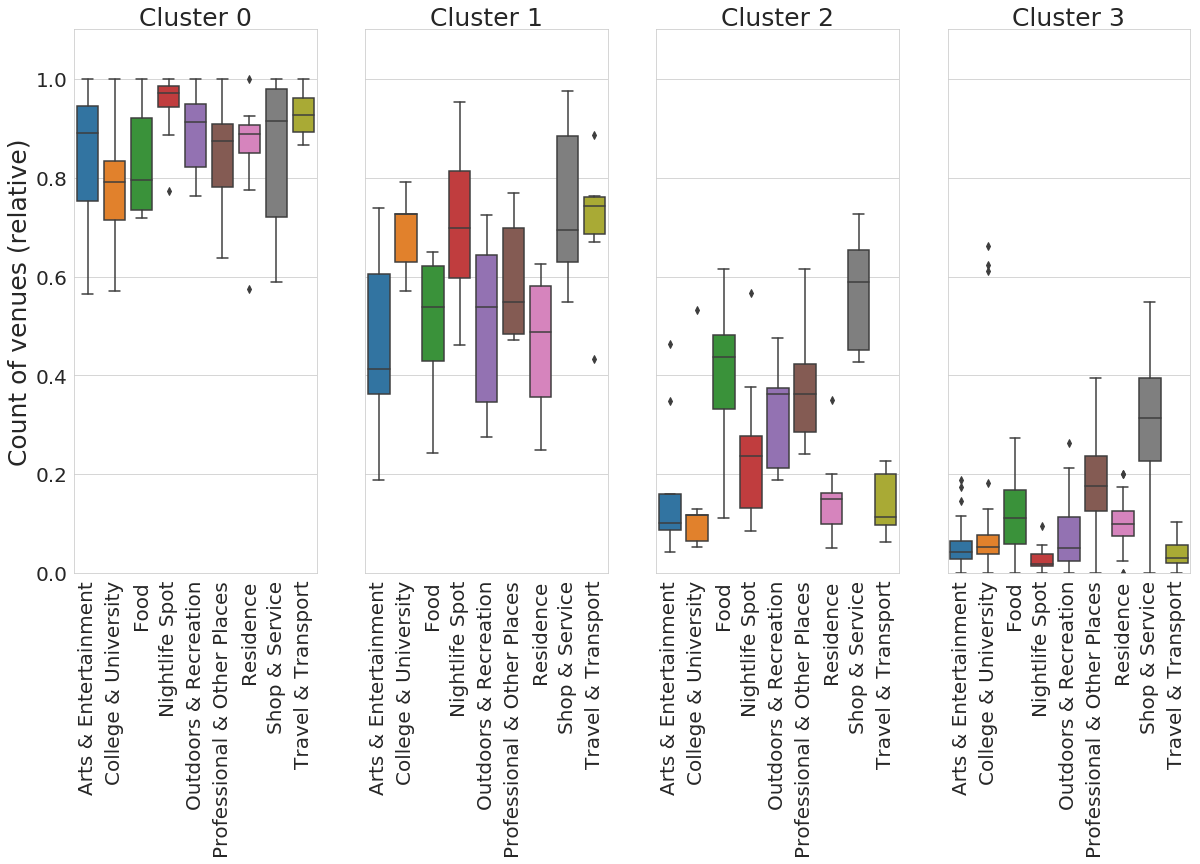

In [41]:
import matplotlib.ticker as ticker

stations_clusters_plot = stations_clusters_minmax_df.copy().drop(columns=['Latitude','Longitude'])
#stations_clusters_plot.drop(columns=['Latitude','Longitude'], inplace=True)

fig, axes = plt.subplots(1,kclusters, figsize=(20, 10), sharey=True)

axes[0].set_ylabel('Count of venues (relative)', fontsize=25)
#plt.set_xlabel('Venue category', fontsize='x-large')

for k in range(kclusters):
    #Set same y axis limits
    axes[k].set_ylim(0,1.1)
    axes[k].xaxis.set_label_position('top')
    axes[k].set_xlabel('Cluster ' + str(k), fontsize=25)
    axes[k].tick_params(labelsize=20)
    plt.sca(axes[k])
    plt.xticks(rotation='vertical')
    sns.boxplot(data = stations_clusters_plot[stations_clusters_plot['Cluster'] == k].drop('Cluster',1), ax=axes[k])

plt.show()

Map the data.

In [34]:
# create map of Montreal using latitude and longitude values
map_montreal_metro = folium.Map(location=[latitude, longitude], zoom_start=12)

#draw_lines(stations_df, map_moscow_metro, 0.9)

#add markers
for i, station, Latitude, Longitude, cluster in zip(stations_clusters_minmax_df.index,
                                         stations_clusters_minmax_df['Name'],
                                         stations_clusters_minmax_df['Latitude'],
                                         stations_clusters_minmax_df['Longitude'],
                                         stations_clusters_minmax_df['Cluster']):
    #latlong = [float(x) for x in coordinates.split(',')]    
    #colors = sns.color_palette(None, kclusters).as_hex()
    colors=['red','orange','blue','green']
    #Calculate top 3 categories for each station
    station_series = stations_clusters_minmax_df.iloc[i]
    top_categories_dict = {}
    for cat in categories_list:
        top_categories_dict[cat[0]] = station_series[cat[0]]
    top_categories = sorted(top_categories_dict.items(), key = lambda x: x[1], reverse=True)
    popup='<b>{}</b><br>Cluster {}<br>1. {} {}<br>2. {} {}<br>3. {} {}'.format(
        station,
        cluster,
        top_categories[0][0],
        "{0:.2f}".format(top_categories[0][1]),
        top_categories[1][0],
        "{0:.2f}".format(top_categories[1][1]),
        top_categories[2][0],
        "{0:.2f}".format(top_categories[2][1]))
    folium.CircleMarker(
        [Latitude,Longitude],
        fill=True,
        fill_opacity=0.5,
        popup=folium.Popup(popup, max_width = 300),
        radius=5,
        color=colors[cluster]
    ).add_to(map_montreal_metro)
    
map_montreal_metro

In [35]:
map_montreal_metro.save('map\index.html')

## Results

We can Search Results interpretate the results as follow:
- Cluster 0 (Red) has consistently high scores for all venue categories. This is the most diversely developed part of the city.
- Cluster 1 (Orange) has highest marks for shop and services Places. This area has the potential for the business and professional jobs.
- Cluster 2 (Blue) has lower marks, but again Shop&Service and Food are dominante venue in this area.
- Cluster 3 (Green) has low marks across the board, except for Shop&Services. These appear to be underdeveloped areas.  

Plotting the clusters on a map shows us that
- Cluster 0 is the central part of the city which is well known for tourist attactions and festivals. Many well-known bussinesses have their headquatre in this zone. This zone known as "Underground City".
- Cluster 1 is also known as downtown. This area is mostly known for resturants and student residentials.
- Clusters 2 and 3 are mostly known as residential areas.


## Conclusion

Montreal has the highest number of restaurants per Capita in Canada and the second in North America after New York. This study proofs this fact.
This study is very general, but it can be customized for any bussiness query, to find the best location.